# Deep Reinforcement Learning for Portfolio Optimization


This experiement demonstrates the application of deep reinforcement learning (DRL) techniques for portfolio optimization.

By leveraging state-of-the-art DRL algorithms, we aim to create a robust trading strategy that dynamically adjusts portfolio allocations to maximize returns while minimizing risks.

Policy network architecture: **MLP backbone**
- Compares `A2C`, `PPO`, `SAC`, `DDPG` all with simple MLPs

The workflow includes:

- Data preprocessing
- Feature engineering
- Environment setup
- Training of DRL agents
- Backtesting
- Benchmarking against traditional strategies


## Dependencies


In [1]:
# ! pip install pandas numpy matplotlib \
#                stable-baselines3 \
#                PyPortfolioOpt \
#                pandas_market_calendars quantstats gymnasium \
#                git+https://github.com/AI4Finance-Foundation/FinRL.git -q

In [28]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import time

import torch

from stable_baselines3 import A2C, PPO, SAC, DDPG
from stable_baselines3.common.noise import NormalActionNoise

from finrl import config
from finrl import config_tickers
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_portfolio_allocation.env_portfolio import StockPortfolioEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.plot import backtest_stats, get_daily_return, get_baseline, convert_daily_return_to_pyfolio_ts

from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models

%matplotlib inline

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [30]:
experiment_name = "portfolio_optimization_mlp"
results_dir = f"results/models/{experiment_name}"
os.makedirs(results_dir, exist_ok=True)

## Data loading and pre-processing


Define training and trading/test periods

In [3]:
start_date = "2015-01-01"
end_date = (datetime.now() - pd.Timedelta(days=1)).strftime("%Y-%m-%d")  # Yesterday

trade_period = 2  # 2 years for testing
train_period = 10  # 10 years for training

train_end_date = (
    datetime.strptime(end_date, "%Y-%m-%d") - timedelta(days=trade_period * 365)
).strftime("%Y-%m-%d")
train_start_date = (
    datetime.strptime(train_end_date, "%Y-%m-%d") - timedelta(days=train_period * 365)
).strftime("%Y-%m-%d")
test_start_date = (
    datetime.strptime(train_end_date, "%Y-%m-%d") + timedelta(days=1)
).strftime("%Y-%m-%d")

train_dates = (train_start_date, train_end_date)
test_dates = (test_start_date, end_date)

print(f"Training period: {train_dates}")
print(f"Testing period: {test_dates}")

Training period: ('2013-04-29', '2023-04-27')
Testing period: ('2023-04-28', '2025-04-26')


- Fetch historical stock data for a given list of tickers within a specified date range.
- We use the DOW_30_TICKER stocks
- The data includes `date`, `close`, `high`, `low`, `open`, `volume`, and `tic` (ticker symbol).

In [4]:
def download_data(tickers, start_date, end_date):
    print(f"Downloading {start_date} → {end_date}")
    return YahooDownloader(
        start_date=start_date, end_date=end_date, ticker_list=tickers
    ).fetch_data()
    
df = download_data(config_tickers.DOW_30_TICKER, start_date, end_date)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

Shape of DataFrame:  (62145, 8)


==========

We apply feature engineering to the dataset of stock data:
- Add technical indicators (e.g., moving averages, RSI).
- Calculate turbulence indicators, which measure market volatility.

This Enhance the dataset with features that are critical for modeling market dynamics and making informed trading decisions.

In [5]:
def preprocess_data(df):
    fe = FeatureEngineer(use_technical_indicator=True, use_turbulence=True)
    return fe.preprocess_data(df)

df_feat = preprocess_data(df)

# TODO: Normalise the data??

Successfully added technical indicators
Successfully added turbulence index


## Covariance & Returns for State


- Calculate the rolling covariance matrices and daily returns for the given dataset of stock prices. 
- This prepares the state representation (the state of the portfolio) for the RL models in the RL environments for portfolio optimization.
- The **rolling covariance matrices** (`cov_list`) capture the relationships between asset returns, while the daily returns (`return_list`) provide information about recent price movements. 
- These metrics are critical for modeling the dynamics of the financial market and making informed trading decisions.

In [6]:
def compute_covariance_and_returns(df_feat, lookback=252):
    df_sorted = df_feat.sort_values(["date", "tic"], ignore_index=True)
    df_sorted.index = df_sorted.date.factorize()[0]
    cov_list, return_list = [], []

    dates = df_sorted.date.unique()
    for i in range(lookback, len(dates)):
        win = df_sorted.loc[i - lookback : i]
        pm = win.pivot_table(index="date", columns="tic", values="close")
        rm = pm.pct_change().dropna()
        cov_list.append(rm.cov().values)
        return_list.append(rm)
    df_cov = pd.DataFrame(
        {"date": dates[lookback:], "cov_list": cov_list, "return_list": return_list}
    )

    return pd.merge(df_feat, df_cov, on="date", how="left").dropna(subset=["cov_list"])


df_all = compute_covariance_and_returns(df_feat)

## Train/Trade split


In [7]:
def split_data(df_all, train_dates, test_dates):
    train = data_split(df_all, *train_dates)
    test = data_split(df_all, *test_dates)
    return train, test

train, test = split_data(df_all, train_dates, test_dates)

## Environment setup


- Create instances of the StockPortfolioEnv class for both training and testing datasets.
- It also wrap the training environment for use with Stable-Baselines3 (SB3).

In [8]:
def configure_environment(train, test, fe):
    stock_dim = len(train.tic.unique())
    env_kwargs = dict(
        stock_dim=stock_dim,  # Number of unique stocks
        hmax=100,  # Maximum number of shares that can be traded
        initial_amount=1e6,  # Initial portfolio value (e.g., $1,000,000)
        transaction_cost_pct=0.001,  # Transaction cost as a percentage (e.g., 0.1%)
        reward_scaling=1e-4,  # Scaling factor for rewards
        state_space=stock_dim,  # State space dimension (equal to stock_dim)
        action_space=stock_dim,  # Action space dimension (equal to stock_dim)
        tech_indicator_list=fe.tech_indicator_list,  # List of technical indicators
    )

    # create the two StockPortfolioEnv objects
    raw_train_env = StockPortfolioEnv(df=train, **env_kwargs)
    raw_test_env  = StockPortfolioEnv(df=test,  **env_kwargs)

    # Wrap the *training* env for SB3
    env_train_sb3, _ = raw_train_env.get_sb_env()

    return env_train_sb3, raw_train_env, raw_test_env, env_kwargs

env_train_sb3, raw_train_env, raw_test_env, env_kwargs = configure_environment(
    train, test, FeatureEngineer()
)

## Training


- We define the configuration for various RL models to be trained in the portfolio optimization environment.
- The training environment (`env_train_sb3`) is wrapped for use with Stable-Baselines3 (SB3).
- The SB3 environment provides the `state` and `action space` dimensions needed for configuring the models.

In [9]:
def prepare_models(env_train_sb3):
    n_actions = env_train_sb3.action_space.shape[-1]
    action_noise = NormalActionNoise(
        mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions)
    )
    model_configs = [
        (A2C, "A2C", {}),
        (PPO, "PPO", {}),
        (SAC, "SAC", {}),
        (DDPG, "DDPG", {"action_noise": action_noise}),
    ]
    return model_configs

model_configs = prepare_models(env_train_sb3)

Train multiple reinforcement learning (RL) models using the specified training environment and configuration.

In [ ]:
def train_models(env_train_sb3, model_configs, save_dir, timesteps=200_000):
    models, training_times = {}, {}

    for cls, name, kwargs in model_configs:
        print(f"Training {name}...")
        start_time = time.time()
        model = cls("MlpPolicy", env_train_sb3, verbose=0, **kwargs)
        model.learn(total_timesteps=timesteps)
        end_time = time.time()
        training_times[name] = (end_time - start_time) / 60
        models[name] = model
        model.save(f"{save_dir}/{name}_mlp_model")
        print(f"{name} training completed in {training_times[name]:.2f} minutes.")

    with open(f"{save_dir}/training_times.txt", "w") as f:
        for name, duration in training_times.items():
            f.write(f"{name}: {duration:.2f} seconds\n")

    return models, training_times

In [11]:
models, training_times = train_models(env_train_sb3, model_configs, results_dir)

Training A2C...
begin_total_asset:1000000.0
end_total_asset:1757078.5887494937
Sharpe:  0.6142441047210841
begin_total_asset:1000000.0
end_total_asset:1629725.9405077123
Sharpe:  0.5451010804844751
begin_total_asset:1000000.0
end_total_asset:1679288.6564508425
Sharpe:  0.5747165330952705
begin_total_asset:1000000.0
end_total_asset:1693954.1888096393
Sharpe:  0.5846748747973026
begin_total_asset:1000000.0
end_total_asset:1752722.2547145032
Sharpe:  0.6168137405611367
begin_total_asset:1000000.0
end_total_asset:1696995.3021091484
Sharpe:  0.5880580972078631
begin_total_asset:1000000.0
end_total_asset:1721930.3461284074
Sharpe:  0.5971860622526333
begin_total_asset:1000000.0
end_total_asset:1696367.989835387
Sharpe:  0.5889532806186856
begin_total_asset:1000000.0
end_total_asset:1683196.5806373227
Sharpe:  0.5809927911166067
begin_total_asset:1000000.0
end_total_asset:1652666.9014970253
Sharpe:  0.5646928498216719
begin_total_asset:1000000.0
end_total_asset:1620606.8144772474
Sharpe:  0.5

/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/stable_baselines3/common/buffers.py:242: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 8.71GB > 4.92GB
  warnings.warn(


begin_total_asset:1000000.0
end_total_asset:1699788.5049816726
Sharpe:  0.5829457333123014
begin_total_asset:1000000.0
end_total_asset:1726162.3051814663
Sharpe:  0.597439053412481
begin_total_asset:1000000.0
end_total_asset:1725192.6661847003
Sharpe:  0.5969216653720208
begin_total_asset:1000000.0
end_total_asset:1725371.1401245885
Sharpe:  0.5970250088014359
begin_total_asset:1000000.0
end_total_asset:1725563.2757118123
Sharpe:  0.5971220455980555
begin_total_asset:1000000.0
end_total_asset:1725579.7394961687
Sharpe:  0.5971362829767168
begin_total_asset:1000000.0
end_total_asset:1725864.6914849202
Sharpe:  0.5973119482201719
begin_total_asset:1000000.0
end_total_asset:1725275.2707672915
Sharpe:  0.5969872474946757
begin_total_asset:1000000.0
end_total_asset:1726176.9732786664
Sharpe:  0.5974510969840583
begin_total_asset:1000000.0
end_total_asset:1725469.1447746553
Sharpe:  0.5970686219566451
begin_total_asset:1000000.0
end_total_asset:1726413.5324315685
Sharpe:  0.5976349905232585


/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/stable_baselines3/common/buffers.py:242: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 8.71GB > 4.01GB
  warnings.warn(


begin_total_asset:1000000.0
end_total_asset:1728269.7675210866
Sharpe:  0.5970318640572829
begin_total_asset:1000000.0
end_total_asset:1762728.615661666
Sharpe:  0.6143743334883337
begin_total_asset:1000000.0
end_total_asset:1741441.8137453927
Sharpe:  0.6035535774755914
begin_total_asset:1000000.0
end_total_asset:1749356.1347409843
Sharpe:  0.6072530276011802
begin_total_asset:1000000.0
end_total_asset:1752436.0486273654
Sharpe:  0.6092060359721433
begin_total_asset:1000000.0
end_total_asset:1758655.9005215005
Sharpe:  0.6122974398547222
begin_total_asset:1000000.0
end_total_asset:1755125.0410273385
Sharpe:  0.6104868781401945
begin_total_asset:1000000.0
end_total_asset:1763076.6035282118
Sharpe:  0.6143656942888713
begin_total_asset:1000000.0
end_total_asset:1751941.6402695675
Sharpe:  0.6088439970742577
begin_total_asset:1000000.0
end_total_asset:1755832.0832827843
Sharpe:  0.611021538805723
begin_total_asset:1000000.0
end_total_asset:1755413.7006123292
Sharpe:  0.6105386030806713
b

In [58]:
training_times_df = pd.DataFrame(
    list(training_times.items()), columns=["model", "training_duration (min)"]
)

training_times_df.to_csv(f"{results_dir}/training_times.csv", index=False)

print("Training summary:")
display(training_times_df)

Training summary:


,model,training_duration (min)
0,A2C,2.788114
1,PPO,2.673218
2,SAC,37.126461
3,DDPG,36.979652


## Model loading

Load the trained models from memory for analysis without the need for time consuming retraining

In [13]:
def load_models(model_configs, exp_name):
    models = {}
    save_dir = f"results/models/{exp_name}"
    for _, name, _ in model_configs:
        model_path = f"{save_dir}/{name}_model.zip"
        if os.path.exists(model_path):
            print(f"Loading saved model for {name}...")
            models[name] = globals()[name].load(model_path)
        else:
            print(f"No saved model found for {name}.")
    return models

if models == {}:
    print("No models loaded. Training will be skipped.")
    models = load_models(model_configs, "po_experiment_2")
    print("Models loaded successfully.")
else:
    print("Models are already trained and loaded.")

Models are already trained and loaded.


## Backtesting

- Evaluates the performance of the RL models/algorithms in a trading environment. 
- We do this by calculating the **cumulative portfolio value** and **performance metrics** for each RL model.

In [14]:
def backtest_rl_strategies(models, raw_env, env_kwargs):
    results = {}
    for name, model in models.items():
        print(f"Backtesting {name}…")
        # Simulate trading using the model in the raw_env environment
        df_ret, _ = DRLAgent.DRL_prediction(
            model=model, environment=raw_env, deterministic=True
        )
        df_ret["account_value"] = (df_ret.daily_return + 1).cumprod() * env_kwargs[
            "initial_amount"
        ]
        stats = backtest_stats(df_ret, value_col_name="account_value")
        results[name] = {"df": df_ret, "stats": stats}
    return results

results = backtest_rl_strategies(models, raw_test_env, env_kwargs)

Backtesting A2C…
begin_total_asset:1000000.0
end_total_asset:1137012.7283036544
Sharpe:  0.540587132936662
hit end!
Annual return          0.066856
Cumulative returns     0.137013
Annual volatility      0.137160
Sharpe ratio           0.541128
Calmar ratio           0.432845
Stability              0.795287
Max drawdown          -0.154457
Omega ratio            1.104160
Sortino ratio          0.781318
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.917692
Daily value at risk   -0.016986
dtype: float64
Backtesting PPO…
begin_total_asset:1000000.0
end_total_asset:1208390.986096754
Sharpe:  0.7715688740205539
hit end!
Annual return          0.100101
Cumulative returns     0.208391
Annual volatility      0.135644
Sharpe ratio           0.772342
Calmar ratio           0.681409
Stability              0.870156
Max drawdown          -0.146903
Omega ratio            1.152571
Sortino ratio          1.137363
Skew                        NaN
Kurtosis         

## Benchmarks


These benchmarks will provide baseline performance metrics for comparison with the RL strategies.
We evaluate the performance of **Mean-Variance Optimization (MVO)** and simple benchmarks (**Equal-Weighted Portfolio** and **SPY**) in terms of returns, volatility, and cumulative portfolio value.

---

### Mean-Variance Optimization Benchmark

- **Objective**: Calculate the benchmark portfolio using **Mean-Variance Optimization (MVO)**.
- **Purpose**: This function benchmarks the performance of a portfolio optimized for minimum volatility using **Modern Portfolio Theory (MPT)**. 
- **Comparison**: It allows us to compare the MPT strategy with other RL strategies by analyzing metrics like returns, volatility, and cumulative performance.

##### Workflow:
1. **Covariance Matrix**:
    - Extract the covariance matrix of asset returns for each trading day in the test period.
    - Use this matrix to model the relationships between asset returns.

2. **Optimization**:
    - Apply **Efficient Frontier** to minimize portfolio volatility.
    - Compute the optimal weights for each asset in the portfolio.

3. **Portfolio Value Calculation**:
    - Calculate the portfolio's account value over time using the optimized weights and asset prices.

4. **Performance Metrics**:
    - Evaluate the portfolio's performance using metrics such as annual return, cumulative return, and volatility.
    - Add the results to the `results` dictionary under the `"MPT"` key.

In [15]:
def compute_mpt_benchmark(test, env_kwargs):
    dates_test = test.date.unique()
    min_vals = [env_kwargs["initial_amount"]]
    for i in range(len(dates_test) - 1):
        curr = test[test.date == dates_test[i]]
        nxt = test[test.date == dates_test[i + 1]]
        covm = np.array(curr.cov_list.values[0])
        ef = EfficientFrontier(None, covm, weight_bounds=(0, 1))
        ef.min_volatility()
        w = ef.clean_weights()
        prices = curr.close.values
        nextp = nxt.close.values
        shares = np.array(list(w.values())) * min_vals[-1] / prices
        min_vals.append(np.dot(shares, nextp))
    min_df = pd.DataFrame({"date": dates_test, "account_value": min_vals})
    stats_mpt = backtest_stats(min_df, value_col_name="account_value")
    return {"df": min_df, "stats": stats_mpt}


mpt_benchmark = compute_mpt_benchmark(test, env_kwargs)

Annual return          0.056258
Cumulative returns     0.114712
Annual volatility      0.110872
Sharpe ratio           0.550020
Calmar ratio           0.537437
Stability              0.848979
Max drawdown          -0.104678
Omega ratio            1.104904
Sortino ratio          0.791591
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.016836
Daily value at risk   -0.013727
dtype: float64


---

### Equal-Weighted Portfolio Benchmark

- Calculate the performance of an **equal-weighted portfolio** benchmark. 
- This benchmark assumes that all assets in the portfolio are equally weighted, and their daily returns are averaged to compute the portfolio's overall return.

##### Workflow:
1. **Daily Returns Calculation**:
    - Group the test dataset by `date`.
    - Compute the percentage change (`pct_change`) in the `close` prices for each group.
    - Calculate the mean of the daily percentage changes to represent the portfolio's daily return.

2. **Cumulative Portfolio Value**:
    - Reset the index of the daily returns to create a DataFrame (`ew_df`).
    - Compute the cumulative product of the daily returns (`cumprod`) to calculate the portfolio's cumulative value over time.
    - Multiply the cumulative returns by the initial portfolio value (`initial_amount`) to get the portfolio's account value.

3. **Performance Metrics**:
    - Use the `backtest_stats` function to calculate performance metrics for the equal-weighted portfolio, such as annual return, cumulative return, and volatility.

In [16]:
def compute_equal_weighted_benchmark(test, env_kwargs):
    ew_daily = test.groupby("date")["close"].apply(
        lambda d: d.pct_change().fillna(0).mean()
    )
    
    ew_df = ew_daily.reset_index(name="daily_return")
    ew_df["account_value"] = (ew_df.daily_return + 1).cumprod() * env_kwargs[
        "initial_amount"
    ]
    stats_ew = backtest_stats(ew_df, value_col_name="account_value")
    return {"df": ew_df, "stats": stats_ew}

ew_benchmark = compute_equal_weighted_benchmark(test, env_kwargs)

Annual return          1.060439e+50
Cumulative returns     1.806826e+99
Annual volatility      2.998347e+00
Sharpe ratio           4.973638e+01
Calmar ratio                    NaN
Stability              9.838576e-01
Max drawdown           0.000000e+00
Omega ratio                     NaN
Sortino ratio                   inf
Skew                            NaN
Kurtosis                        NaN
Tail ratio             2.155289e+00
Daily value at risk    2.140173e-01
dtype: float64


---

### SPY Benchmark

- **Objective**: Calculate the benchmark performance of the `SPY ETF`, which tracks the **S&P 500** index.
- **Purpose**: This function provides a baseline for comparing the performance of reinforcement learning models and other portfolio strategies.

##### Workflow:
1. **Data Retrieval**:
     - Use the `get_baseline` function to fetch the historical closing prices of the SPY ETF for the test period.
2. **Daily Returns Calculation**:
     - Compute the percentage change (`pct_change`) in the SPY closing prices to calculate daily returns.
3. **Cumulative Portfolio Value**:
     - Create a DataFrame (`spy_df`) with the daily returns and calculate the cumulative product (`cumprod`) of the daily returns to compute the portfolio's cumulative value over time.
     - Multiply the cumulative returns by the initial portfolio value (`initial_amount`) to get the portfolio's account value.
4. **Performance Metrics**:
     - Use the `backtest_stats` function to calculate performance metrics for the SPY benchmark, such as annual return, cumulative return, and volatility.

In [17]:
def compute_spy_benchmark(test, env_kwargs):
    spy_close = get_baseline("SPY", test.date.min(), test.date.max())["close"]
    spy_ret = spy_close.pct_change().dropna()
    spy_df = pd.DataFrame({"date": spy_ret.index, "daily_return": spy_ret.values})
    spy_df["account_value"] = (spy_df.daily_return + 1).cumprod() * env_kwargs[
        "initial_amount"
    ]
    stats_spy = backtest_stats(spy_df, value_col_name="account_value")
    return {"df": spy_df, "stats": stats_spy}

spy_benchmark = compute_spy_benchmark(test, env_kwargs)

[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (499, 8)
Annual return          0.164761
Cumulative returns     0.351750
Annual volatility      0.164207
Sharpe ratio           1.012298
Calmar ratio           0.878478
Stability              0.877736
Max drawdown          -0.187552
Omega ratio            1.214904
Sortino ratio          1.503042
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.914012
Daily value at risk   -0.020028
dtype: float64


In [18]:
benchmarks = {
    "MPT": mpt_benchmark,
    "EW": ew_benchmark,
    "SPY": spy_benchmark,
}

results.update(benchmarks)

## Performance Summary


In [19]:
perf_stats = pd.DataFrame({key.upper(): res["stats"] for key, res in results.items()})
display(perf_stats)

,A2C,PPO,SAC,DDPG,MPT,EW,SPY
Annual return,0.066856,0.100101,0.103656,0.125732,0.056258,1.060439e+50,0.164761
Cumulative returns,0.137013,0.208391,0.216152,0.264893,0.114712,1.806826e+99,0.351750
Annual volatility,0.137160,0.135644,0.137244,0.138752,0.110872,2.998347e+00,0.164207
Sharpe ratio,0.541128,0.772342,0.788471,0.924471,0.550020,4.973638e+01,1.012298
Calmar ratio,0.432845,0.681409,0.664502,0.827112,0.537437,NaN,0.878478
Stability,0.795287,0.870156,0.883419,0.897553,0.848979,9.838576e-01,0.877736
Max drawdown,-0.154457,-0.146903,-0.155991,-0.152014,-0.104678,0.000000e+00,-0.187552
Omega ratio,1.104160,1.152571,1.156503,1.187902,1.104904,NaN,1.214904
Sortino ratio,0.781318,1.137363,1.160242,1.373466,0.791591,inf,1.503042
Skew,NaN,NaN,NaN,NaN,NaN,NaN,NaN


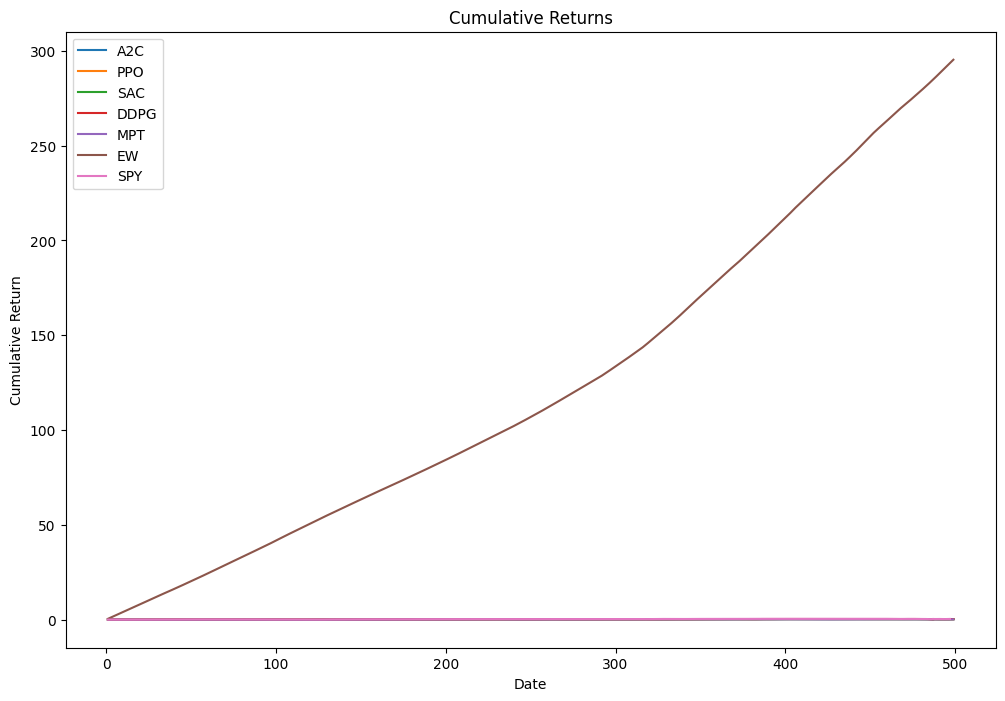

In [20]:
def plot_cumulative_returns(results):
    plt.figure(figsize=(12, 8))
    for name, result in results.items():
        cumulative_return = result["df"]["account_value"].pct_change().cumsum()
        plt.plot(cumulative_return.index, cumulative_return.values, label=name)
    plt.xlabel("Date")
    plt.ylabel("Cumulative Return")
    plt.title("Cumulative Returns")
    plt.legend()
    plt.show()
plot_cumulative_returns(results)

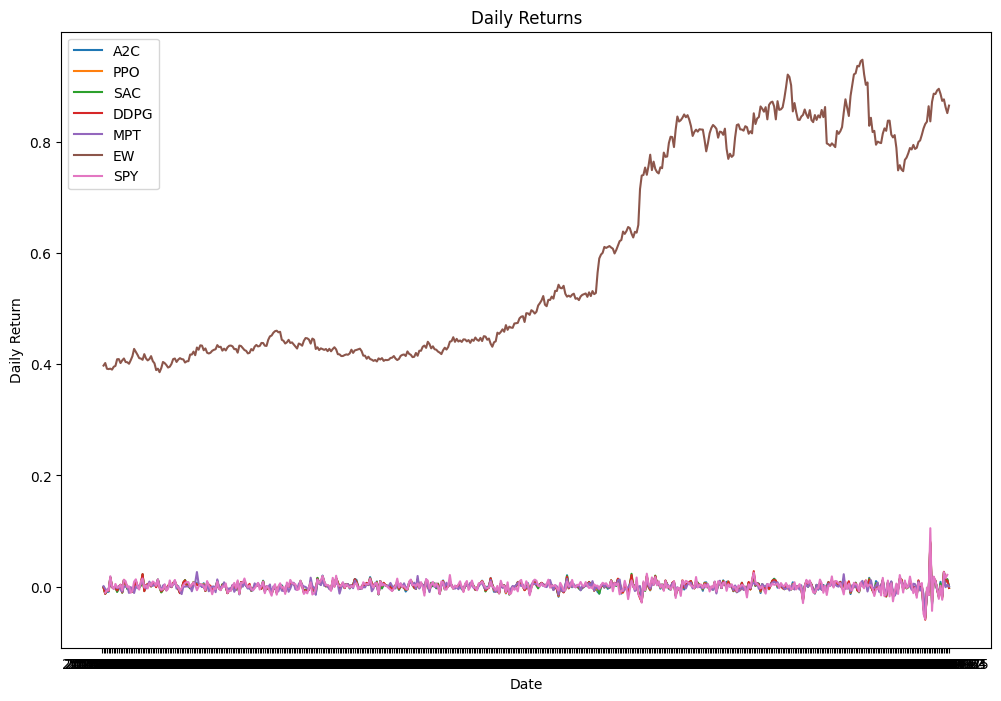

In [21]:
def plot_daily_returns(results):
    plt.figure(figsize=(12, 8))
    for name, result in results.items():
        daily_return = get_daily_return(result["df"], value_col_name="account_value")
        plt.plot(result["df"]["date"], daily_return.values, label=name)
    plt.xlabel("Date")
    plt.ylabel("Daily Return")
    plt.title("Daily Returns")
    plt.legend()
    plt.show()

plot_daily_returns(results)

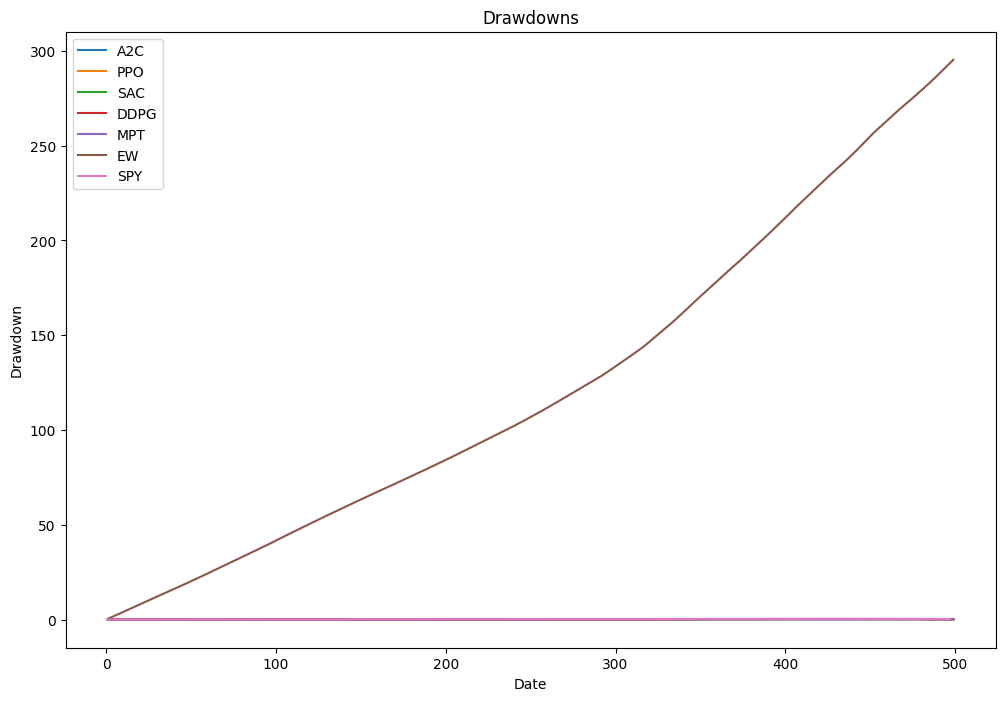

In [22]:
def plot_drawdowns(results):
    plt.figure(figsize=(12, 8))
    for name, result in results.items():
        drawdown = result["df"]["account_value"].pct_change().cumsum()
        plt.plot(drawdown.index, drawdown.values, label=name)
    plt.xlabel("Date")
    plt.ylabel("Drawdown")
    plt.title("Drawdowns")
    plt.legend()
    plt.show()
    
plot_drawdowns(results)

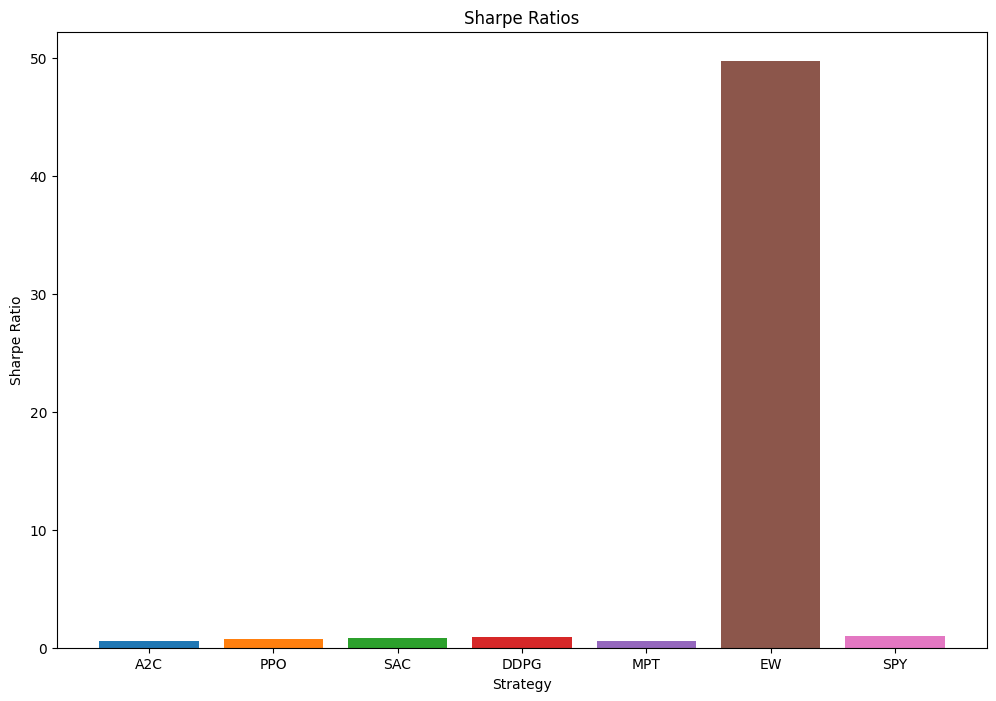

In [23]:
def plot_sharpe_ratios(results):
    plt.figure(figsize=(12, 8))
    for name, result in results.items():
        sharpe_ratio = result["stats"].to_dict()['Sharpe ratio']
        plt.bar(name, sharpe_ratio)
    plt.xlabel("Strategy")
    plt.ylabel("Sharpe Ratio")
    plt.title("Sharpe Ratios")
    plt.show()
    
plot_sharpe_ratios(results)

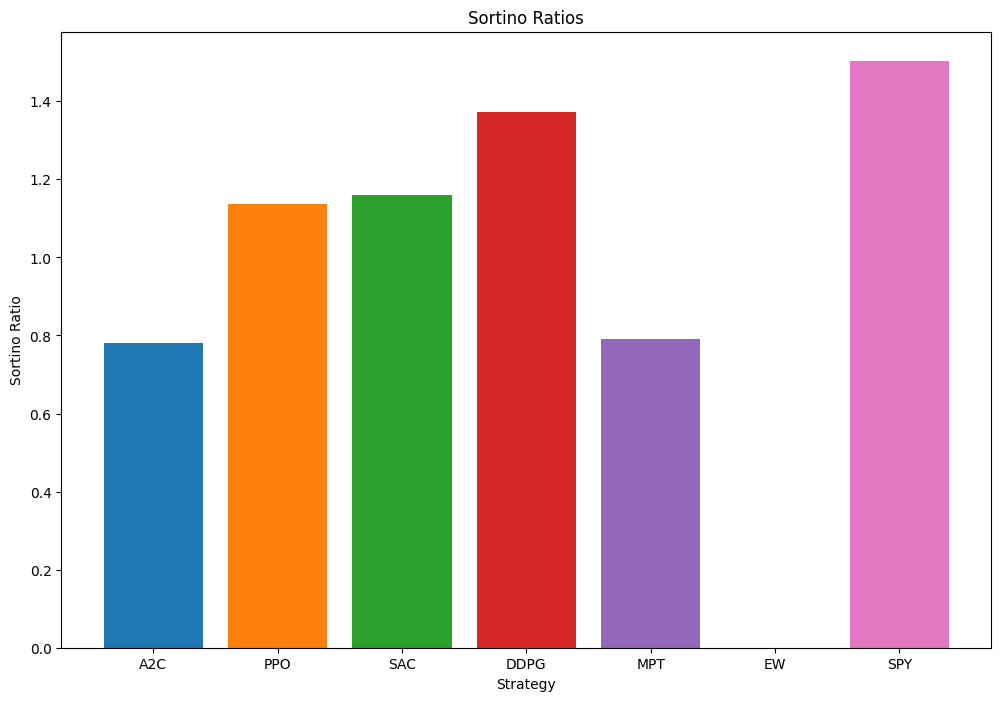

In [24]:
def plot_sortino_ratios(results):
    plt.figure(figsize=(12, 8))
    for name, result in results.items():
        sortino_ratio = result["stats"].to_dict()['Sortino ratio']
        plt.bar(name, sortino_ratio)
    plt.xlabel("Strategy")
    plt.ylabel("Sortino Ratio")
    plt.title("Sortino Ratios")
    plt.show()
plot_sortino_ratios(results)

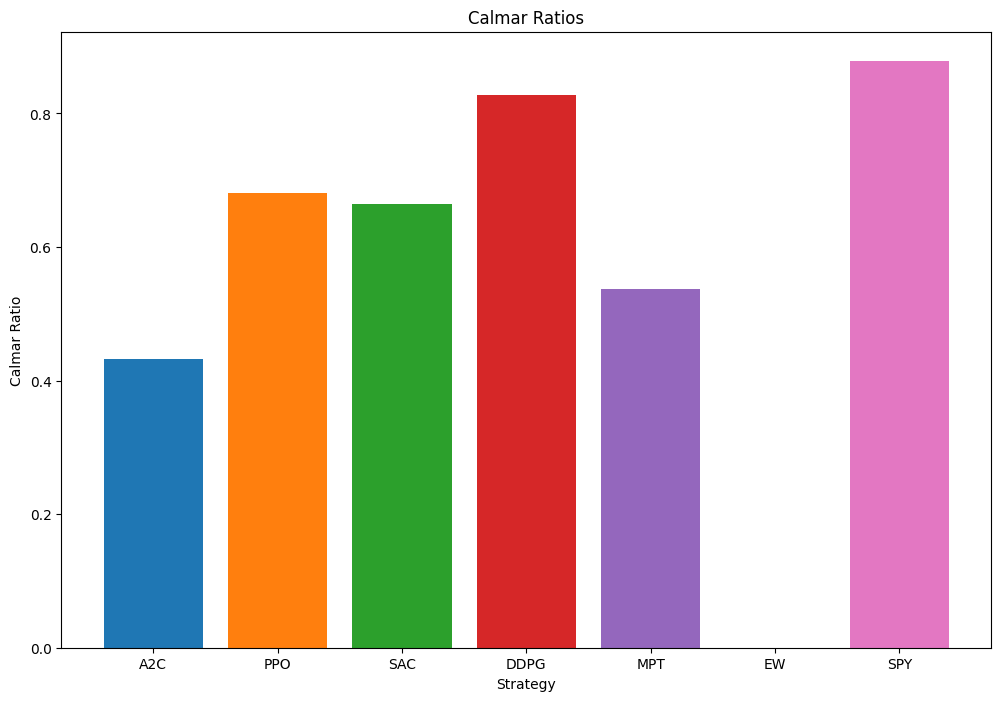

In [25]:
def plot_calmar_ratios(results):
    plt.figure(figsize=(12, 8))
    for name, result in results.items():
        calmar_ratio = result["stats"].to_dict()['Calmar ratio']
        plt.bar(name, calmar_ratio)
    plt.xlabel("Strategy")
    plt.ylabel("Calmar Ratio")
    plt.title("Calmar Ratios")
    plt.show()
    
plot_calmar_ratios(results)

Visualize the cumulative returns of various strategies over time

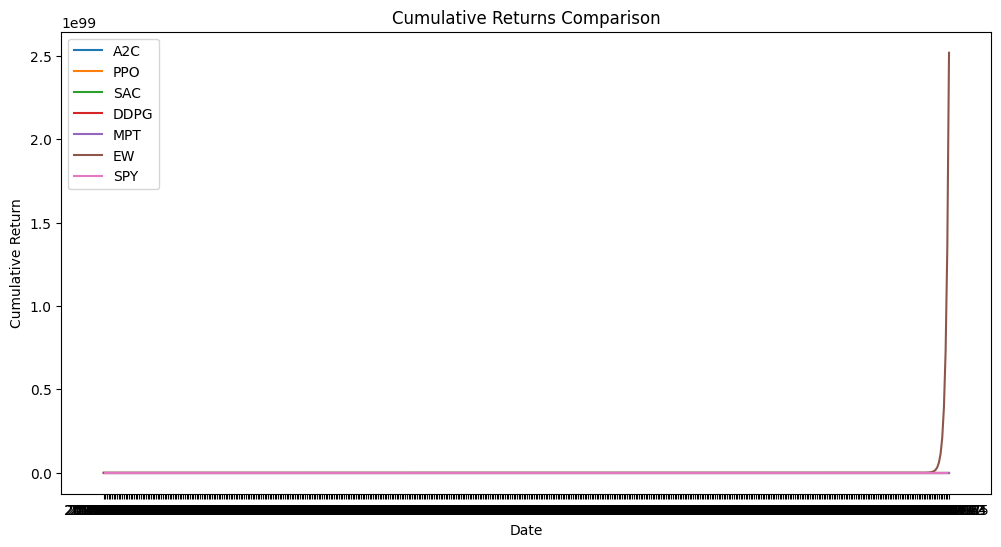

In [26]:
def plot_performance(results):
    plt.figure(figsize=(12, 6))
    for name, res in results.items():
        df = res["df"]
        if "daily_return" in df.columns:
            # RL models, EW, SPY
            cum = (df["daily_return"] + 1).cumprod() - 1
        elif "account_value" in df.columns:
            # MPT (and any other account_value–only series)
            cum = df["account_value"] / df["account_value"].iloc[0] - 1
            # cum = (df["account_value"].pct_change() + 1).cumprod() - 1
        else:
            # nothing to plot
            continue

        plt.plot(df["date"], cum, label=name)

    plt.legend()
    plt.title("Cumulative Returns Comparison")
    plt.xlabel("Date")
    plt.ylabel("Cumulative Return")
    plt.show()

plot_performance(results)
